In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
df = pd.read_csv("train.csv")

# 前処理
# idカラムは特徴量ではないのでdropしておく
df.drop(["id"], axis=1, inplace=True)
# targetのラベルエンコーディング
le = LabelEncoder()
df["target"] = le.fit_transform(df["target"])

X = df.drop(["target"], axis=1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# それぞれのスコアを格納する dict を用意する
scores = {}

## ロジスティック回帰による分類

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_score = accuracy_score(y_test, lr_pred)
scores["LogisticRegression"] = lr_score

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


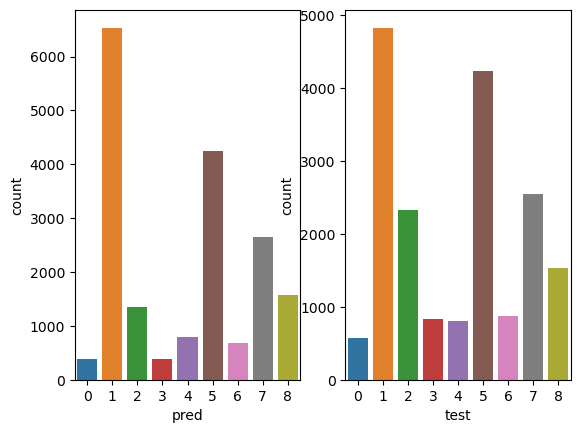

In [3]:
# 可視化
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.countplot(lr_pred, ax=ax1)
ax1.set_xlabel("pred")
sns.countplot(y_test, ax=ax2)
ax2.set_xlabel("test")
fig.show()

## ランダムフォレストによる分類
### ランダムフォレストとは
バギングに少し工夫を加えたアルゴリズム。  
**バギング+決定木+特徴量のランダム選択** を組み合わせたもの  
**特徴量をランダムに選択することでそれぞれのモデルの相関を減らし、アンサンブルの精度を上げるという発想。**  

In [4]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
rfc_score = accuracy_score(y_test, rfc_pred)
scores["RandomForest"] = rfc_score

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


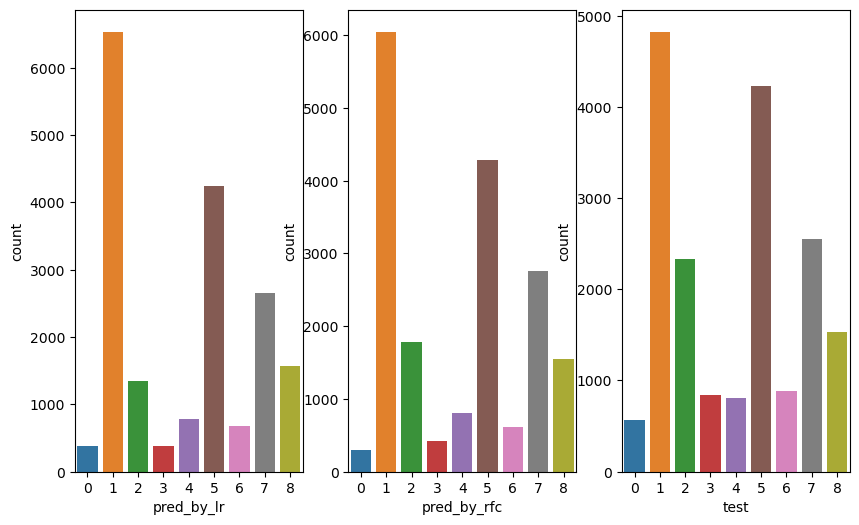

In [5]:
# LogisticRegressionとRandomForestの可視化
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(10, 6)
sns.countplot(lr_pred, ax=ax1)
ax1.set_xlabel("pred_by_lr")
sns.countplot(rfc_pred, ax=ax2)
ax2.set_xlabel("pred_by_rfc")
sns.countplot(y_test, ax=ax3)
ax3.set_xlabel("test")
fig.show()

LogisticRegressionとRandomForestと真の分類を比較した図 
### サポートベクターマシーンによる予測
**“直近のデータからある程度余裕をもった方が未知のデータにも対応できる”という直感をアルゴリズムにしたもの**

あるデータがサポートとなり(**サポートとなったデータをサポートベクターと呼ぶ**)、そこからのマージン(距離)が最大化する(境界線に余裕を持たせる)ように決定境界を引く。(距離を使うので事前に標準化しておく必要がある)

In [6]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
svm_score = accuracy_score(y_test, svm_pred)
scores["SVM"] = svm_score

サポートベクターマシーンは、リソース不足のためか学習を終えることができなかった

### Light GBMによる予測

In [8]:
import lightgbm as lgb
lgbmc = lgb.LGBMClassifier(boosting_type="goss", max_depth=5, random_state=0)
eval_set = [(X_test, y_test)]
callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=10))
callbacks.append(lgb.log_evaluation())
lgbmc.fit(X_train, y_train, eval_set=eval_set, callbacks=callbacks)
lgbm_pred = lgbmc.predict(X_test)
lgbm_score = accuracy_score(y_test, lgbm_pred)
scores["lightGBM"] = lgbm_score

[1]	valid_0's multi_logloss: 1.62326
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 1.45753
[3]	valid_0's multi_logloss: 1.33452
[4]	valid_0's multi_logloss: 1.23849
[5]	valid_0's multi_logloss: 1.15986
[6]	valid_0's multi_logloss: 1.09506
[7]	valid_0's multi_logloss: 1.03934
[8]	valid_0's multi_logloss: 0.992798
[9]	valid_0's multi_logloss: 0.950952
[10]	valid_0's multi_logloss: 0.915171
[11]	valid_0's multi_logloss: 0.883578
[12]	valid_0's multi_logloss: 0.856136
[13]	valid_0's multi_logloss: 0.831925
[14]	valid_0's multi_logloss: 0.80959
[15]	valid_0's multi_logloss: 0.789853
[16]	valid_0's multi_logloss: 0.772682
[17]	valid_0's multi_logloss: 0.757633
[18]	valid_0's multi_logloss: 0.743339
[19]	valid_0's multi_logloss: 0.730906
[20]	valid_0's multi_logloss: 0.719369
[21]	valid_0's multi_logloss: 0.70773
[22]	valid_0's multi_logloss: 0.698713
[23]	valid_0's multi_logloss: 0.689701
[24]	valid_0's multi_logloss: 0.682594
[25]	valid_0's multi_

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


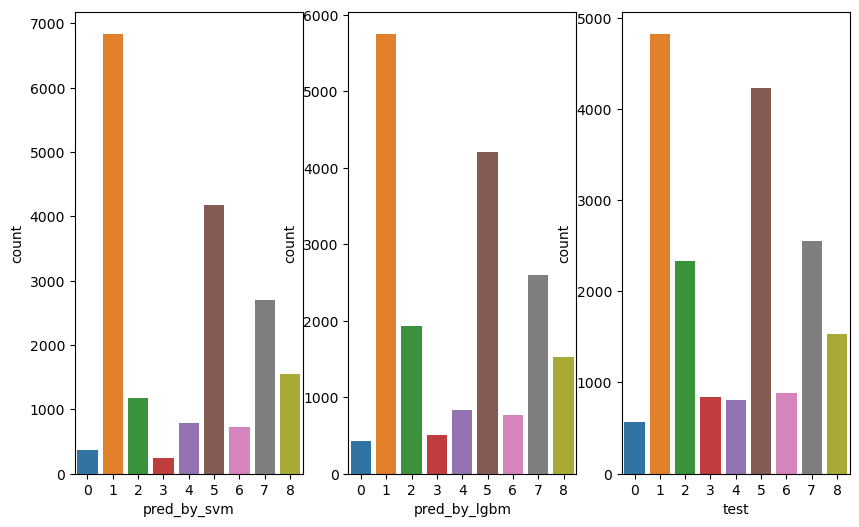

In [9]:
# SVMとLightGBMの可視化
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(10, 6)
sns.countplot(svm_pred, ax=ax1)
ax1.set_xlabel("pred_by_svm")
sns.countplot(lgbm_pred, ax=ax2)
ax2.set_xlabel("pred_by_lgbm")
sns.countplot(y_test, ax=ax3)
ax3.set_xlabel("test")
fig.show()

In [10]:
print(scores)

{'LogisticRegression': 0.7601809954751131, 'RandomForest': 0.8006895065718596, 'SVM': 0.77650290885585, 'lightGBM': 0.7922861452273217}
